In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import mat73

def plot_setup():
    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k',
                           'axes.labelcolor':'k',
                           'text.color':'k',
                           'font.family':'sans-serif',
                           'font.sans-serif':['Arial'],
                           'text.usetex':False,
                           'pdf.fonttype':42,
                           'ps.fonttype':42,
                            })

plot_setup()
sns.set_context('talk')





# model 0 

- cdc42 with conservation, activation rate linearly increases with $r$
- receptor is stimulated for appropriate time $t_\textrm{s}$ with strength $s$:

\begin{align} 
\frac{dc}{dt} &= -k_0 c + (k_1 + k_{11} r) (c_{\textrm{tot}} - c)\\
\frac{dr}{dt} &= s H(t_{s} - t) H(t) - k_2 r
\end{align}

In [12]:
def f(t, y, p):
    """
    cdc42 model
    """
    try:
        k0 = p['k0'].value
        k1 = p['k1'].value
        k2 = p['k2'].value
        k11 = p['k11'].value
        ts = p['ts'].value
        s = p['s'].value
        ct = p['ct'].value
    except:        
        k0, k1, k2, k11, ts, s, ct, c0, r0 = p

    c = y[0]
    r = y[1]
    dcdt = -k0*c + (k1 + k11*r)*(ct - c)
    drdt = s*np.heaviside(ts-t,1)*np.heaviside(t,1) - k2*r
    dy = [dcdt,drdt]
    return dy

def g(t, y0, p):
    """
    solution to the ode with initial condition
    """
    sol = solve_ivp(lambda t,y: f(t, y, p), [0, 200], y0, t_eval=t, method='Radau', rtol=1e-8, atol=1e-8)
    return sol.y

def residual(p, t, data):
    """
    residual function
    """
    y0 = [p['c0'].value, p['r0'].value]
    model = g(t, y0, p)
    return (model[0] - data).ravel()



In [13]:
v1 = mat73.loadmat('pDatPDL20201022v1.mat', use_attrdict = True)
ms = v1['pDatPDL20201022v1']
idx = np.array([27])
t = np.array(ms['meanTKtime'])[idx].flatten()
data = np.array(ms['meanNormRatio'])[idx].flatten()


In [14]:
#start at time zero (this needs to be updated everytime)
t = t[9:]
data = data[9:]

In [15]:
params = Parameters()
params.add('k0', value = 0.1, min = 0)
params.add('k1', value = 0.1, min = 0)
params.add('k2', value = 0.1, min = 0)
params.add('k11', value = 0.1, min = 0)
params.add('s', value = 0.05, min = 0)
params.add('ct', value = 2, min = 1)
params.add('ts', value = 100, vary = False)
params.add('c0', value = 1, vary = False)
params.add('r0', value = 0, vary = False)

result = minimize(residual, params, args = (t, data), method = 'nelder')
final = data + result.residual.reshape(data.shape)




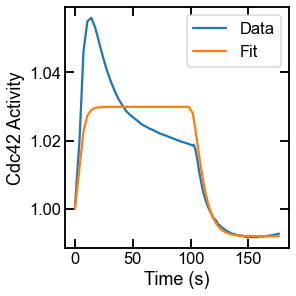

In [16]:
fig, ax = plt.subplots(1,1, figsize = (4,4), constrained_layout = True)
ax.plot(t, data, label='Data')
ax.plot(t, final, label='Fit')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cdc42 Activity')
# ax.set_ylim([0.98,1.06])
l = ax.legend()




In [17]:
report_fit(result)



[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1701
    # data points      = 81
    # variables        = 6
    chi-square         = 0.00464824
    reduced chi-square = 6.1977e-05
    Akaike info crit   = -779.023015
    Bayesian info crit = -764.656320
[[Variables]]
    k0:   0.00833012 +/- 0.00314921 (37.81%) (init = 0.1)
    k1:   0.14189403 +/- 0.03870201 (27.28%) (init = 0.1)
    k2:   0.27792519 +/- 0.06000451 (21.59%) (init = 0.1)
    k11:  0.41284466 +/- 0.13865682 (33.59%) (init = 0.1)
    s:    0.18732892 +/- 0.07263710 (38.78%) (init = 0.05)
    ct:   1.05030246 +/- 0.01002334 (0.95%) (init = 2)
    ts:   100 (fixed)
    c0:   1 (fixed)
    r0:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k0, k1)  =  0.921
    C(k0, ct)  =  0.795
    C(k1, ct)  =  0.502
    C(k1, k2)  = -0.469
    C(k11, s)  = -0.464
    C(s, ct)   = -0.433
    C(k11, ct) = -0.392
    C(k0, k2)  = -0.324
    C(k0, k11) = -0.264
    C(k0, s)   = -0.

## try negative feedback for overshoot

- cdc42 with conservation, activation rate linearly increases with $r$
- receptor is stimulated for appropriate time $t_\textrm{s}$ with strength $s$:
- negative feedback through GAP (which is produced from cdc42)

\begin{align} 
\frac{dc}{dt} &= - (k_0 + k_{00} g) c + (k_1 + k_{11} r) (c_{\textrm{tot}} - c)\\
\frac{dr}{dt} &= s H(t_{s} - t) H(t) - k_2 r\\
\frac{dg}{dt} &= k_3 c - k_4 g
\end{align}

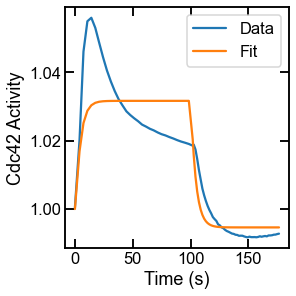

In [18]:
def f(t, y, p):
    """
    cdc42 model
    """
    try:
        k0 = p['k0'].value
        k1 = p['k1'].value
        k2 = p['k2'].value
        k11 = p['k11'].value
        ts = p['ts'].value
        s = p['s'].value
        ct = p['ct'].value
        k00 = p['k00'].value
        k3 = p['k3'].value
        k4 = p['k4'].value
    except:        
        k0, k1, k2, k11, ts, s, ct, c0, r0, k00, k3, k4 = p

    c = y[0]
    r = y[1]
    g = y[2]
    dcdt = -(k0 + k00*g) * c + (k1 + k11*r)*(ct - c)
    drdt = s*np.heaviside(ts-t,1)*np.heaviside(t,1) - k2*r
    dgdt = k3 * c - k4 * g
    dy = [dcdt,drdt,dgdt]
    return dy

def g(t, y0, p):
    """
    solution to the ode with initial condition
    """
    sol = solve_ivp(lambda t,y: f(t, y, p), [0, 200], y0, t_eval=t, method='Radau', rtol=1e-8, atol=1e-8)
    return sol.y

def residual(p, t, data):
    """
    residual function
    """
    y0 = [p['c0'].value, p['r0'].value, p['k3'].value/p['k4'].value]
    model = g(t, y0, p)
    return (model[0] - data).ravel()

params = Parameters()
params.add('k0', value = 1, min = 0)
params.add('k1', value = 1, min = 0)
params.add('k2', value = 1, min = 0)
params.add('k11', value = 1, min = 0)
params.add('s', value = 0.05, min = 0)
params.add('ct', value = 2, min = 1)
params.add('ts', value = 100, vary = False)
params.add('c0', value = 1, vary = False)
params.add('r0', value = 0, vary = False)
params.add('k00', value = 1, min = 0)
params.add('k3', value = 1, min = 0)
params.add('k4', value = 1, min = 0)
           

result = minimize(residual, params, args = (t, data), method = 'nelder')
final = data + result.residual.reshape(data.shape)


fig, ax = plt.subplots(1,1, figsize = (4,4), constrained_layout = True)
ax.plot(t, data, label='Data')
ax.plot(t, final, label='Fit')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cdc42 Activity')
# ax.set_ylim([0.98,1.06])
l = ax.legend()




In [19]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 795
    # data points      = 81
    # variables        = 9
    chi-square         = 0.00500462
    reduced chi-square = 6.9509e-05
    Akaike info crit   = -767.039344
    Bayesian info crit = -745.489302
[[Variables]]
    k0:   0.79656720 +/- 0.47077343 (59.10%) (init = 1)
    k1:   1.51241866 +/- 0.35515798 (23.48%) (init = 1)
    k2:   0.23670836 +/- 0.07764531 (32.80%) (init = 1)
    k11:  0.36616170 +/- 0.35219754 (96.19%) (init = 1)
    s:    0.09888695 +/- 0.07482228 (75.66%) (init = 0.05)
    ct:   1.80462803 +/- 0.04525030 (2.51%) (init = 2)
    ts:   100 (fixed)
    c0:   1 (fixed)
    r0:   0 (fixed)
    k00:  0.82226721 +/- 0.49673006 (60.41%) (init = 1)
    k3:   1.09208472 +/- 0.06331002 (5.80%) (init = 1)
    k4:   2.05274831 +/- 0.58542012 (28.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(ct, k3)   = -6.112
    C(s, k3)    = -3.881
    C(k11, k3)  =  3.635
   

## try positive and negative feedback for overshoot

- cdc42 with conservation, activation rate linearly increases with $r$
- receptor is stimulated for appropriate time $t_\textrm{s}$ with strength $s$:
- negative feedback through GAP (which is produced from cdc42)
- positive feedback through PAK (which is produced from cdc42)

\begin{align} 
\frac{dc}{dt} &= - (k_0 + k_{00} g) c + (k_1 + k_{11} r + k_{12} p) (c_{\textrm{tot}} - c)\\
\frac{dr}{dt} &= s H(t_{s} - t) H(t) - k_2 r\\
\frac{dg}{dt} &= k_3 c - k_4 g \\
\frac{dp}{dt} &= k_5 c - k_6 p
\end{align}

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 7077
    # data points      = 81
    # variables        = 12
    chi-square         = 0.00304786
    reduced chi-square = 4.4172e-05
    Akaike info crit   = -801.209052
    Bayesian info crit = -772.475662
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:   1.07173431 +/-        nan (nan%) (init = 0.1)
    k1:   0.63302633 +/- 0.00318688 (0.50%) (init = 0.1)
    k2:   0.19548140 +/- 0.00535367 (2.74%) (init = 0.1)
    k11:  0.08707254 +/- 0.00248299 (2.85%) (init = 0.1)
    s:    0.07744316 +/-        nan (nan%) (init = 0.1)
    ct:   10.8270091 +/- 0.01040547 (0.10%) (init = 2)
    ts:   100 (fixed)
    c0:   1 (fixed)
    r0:   0 (fixed)
    k00:  0.87464415 +/- 0.01497419 (1.71%) (init = 0.1)
    k3:   0.22275934 +/-        nan (nan%) (init = 0.1)
    k4:   0.00656937 +/-        nan (nan%) (init = 0.1)
    k5:   1.43530547 +/-        nan (nan%) (init = 0.1)
    k6:   0.24282996 +

/Users/colezmurchok/enviro/cdc42/lib/python3.8/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/colezmurchok/enviro/cdc42/lib/python3.8/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


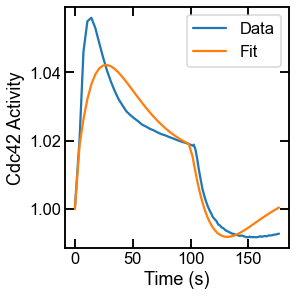

In [20]:
def f(t, y, p):
    """
    cdc42 model
    """
    try:
        k0 = p['k0'].value
        k1 = p['k1'].value
        k2 = p['k2'].value
        k11 = p['k11'].value
        ts = p['ts'].value
        s = p['s'].value
        ct = p['ct'].value
        k00 = p['k00'].value
        k3 = p['k3'].value
        k4 = p['k4'].value
        k5 = p['k5'].value
        k6 = p['k6'].value
        k12 = p['k12'].value
    except:        
        k0, k1, k2, k11, ts, s, ct, c0, r0, k00, k3, k4, k5, k6, k12 = p

    c = y[0]
    r = y[1]
    g = y[2]
    pak = y[3]
    dcdt = -(k0 + k00*g) * c + (k1 + k11*r + k12*pak)*(ct - c)
    drdt = s*np.heaviside(ts-t,1)*np.heaviside(t,1) - k2*r
    dgdt = k3 * c - k4 * g
    dpakdt = k5 * c - k6 * pak
    dy = [dcdt,drdt,dgdt,dpakdt]
    return dy

def g(t, y0, p):
    """
    solution to the ode with initial condition
    """
    sol = solve_ivp(lambda t,y: f(t, y, p), [0, 200], y0, t_eval=t, method='Radau', rtol=1e-6, atol=1e-6)
    return sol.y

def residual(p, t, data):
    """
    residual function
    """
    y0 = [p['c0'].value, p['r0'].value, p['k3'].value/p['k4'].value, p['k5'].value/p['k6'].value]
    model = g(t, y0, p)
    return (model[0] - data).ravel()

params = Parameters()
params.add('k0', value = 0.1, min = 0)
params.add('k1', value = 0.1, min = 0)
params.add('k2', value = 0.1, min = 0)
params.add('k11', value = 0.1, min = 0)
params.add('s', value = 0.1, min = 0)
params.add('ct', value = 2, min = 1)
params.add('ts', value = 100, vary = False)
params.add('c0', value = 1, vary = False)
params.add('r0', value = 0, vary = False)
params.add('k00', value = 0.1, min = 0)
params.add('k3', value = 0.1, min = 0)
params.add('k4', value = 0.1, min = 0)
params.add('k5', value = 0.1, min = 0)
params.add('k6', value = 0.1, min = 0)
params.add('k12', value = 0.1, min = 0)
           

result = minimize(residual, params, args = (t, data), method = 'nelder')
final = data + result.residual.reshape(data.shape)


fig, ax = plt.subplots(1,1, figsize = (4,4), constrained_layout = True)
ax.plot(t, data, label='Data')
ax.plot(t, final, label='Fit')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cdc42 Activity')
# ax.set_ylim([0.98,1.06])
l = ax.legend()


report_fit(result)